# Грузим библиотеки

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns; sns.set()

## Грузим фотки с диска и формируем выборку

In [ ]:
import glob
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


Делаем фотки размера 64х64

In [ ]:
from tqdm import tqdm

dirname = "/gdrive/My Drive/Photo"
labels = ['class1', 'class2', 'class3', 'class4']
x, y = [], []
Crop = True
for label in labels:
    subdir = os.path.join(dirname, label)
    filelist = os.listdir(subdir)
    for fname in tqdm(filelist):
        img = cv2.imread(os.path.join(subdir, fname), cv2.IMREAD_GRAYSCALE)
        if Crop is True:
            img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA)
            face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml')
            face = face_cascade.detectMultiScale(img)
            for (a, b, w, h) in face:
                cv2.rectangle(img, (a, b), (a+w, b+h), (0, 0, 255), 2)
                face = img[b:b + h, a:a + w]
        else:
           face = img
        try:
            h, w = face.shape
            size = min(h, w)
            h0 = int((h - size) / 2)
            w0 = int((w - size) / 2)
        
            img = face[h0: h0 + size, w0: w0 + size]
            img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
            x.append(img)
            y.append(label)
        except:
            print(f'no face found for {fname}')
len(x), len(y)

 13%|█▎        | 4/31 [00:02<00:16,  1.68it/s]

no face found for IMG_1867.JPG


 26%|██▌       | 8/31 [00:04<00:11,  1.97it/s]

no face found for 580833D1-DCBE-4A79-AB06-57B9D091B933.jpg


 71%|███████   | 22/31 [00:13<00:07,  1.18it/s]

no face found for IMG_3428.JPG


 81%|████████  | 25/31 [00:15<00:03,  1.62it/s]

no face found for 209F2DAF-56A3-4477-ABDA-ABF4A0A94353.jpg


 84%|████████▍ | 26/31 [00:15<00:03,  1.54it/s]

no face found for IMG_1103.PNG


100%|██████████| 31/31 [00:18<00:00,  1.65it/s]

no face found for IMG_4667.JPG



 20%|██        | 7/35 [00:03<00:12,  2.33it/s]

no face found for IMG_1837.PNG


 51%|█████▏    | 18/35 [00:08<00:07,  2.13it/s]

no face found for IMG_1886.PNG


 91%|█████████▏| 32/35 [00:14<00:01,  2.19it/s]

no face found for IMG_1831.PNG


 13%|█▎        | 3/23 [00:03<00:23,  1.19s/it]

no face found for IMG_9149.JPG


 22%|██▏       | 5/23 [00:05<00:19,  1.07s/it]

no face found for IMG_0117.JPG


 48%|████▊     | 11/23 [00:14<00:23,  1.93s/it]

no face found for IMG_9833.PNG


 57%|█████▋    | 13/23 [00:16<00:14,  1.50s/it]

no face found for IMG_7747.JPG


 87%|████████▋ | 20/23 [00:26<00:04,  1.50s/it]

no face found for IMG_0258.PNG


100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


(125, 125)

Классы фотографий нумеруем

In [ ]:
labels = {'class1' : 0, 'class2' : 1, 'class3' : 2, 'class4' : 3}
y = [labels[item] for item in y]

Выведем первые три изображения, чтобы понять, что все ок

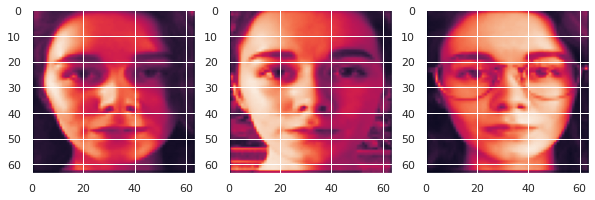

In [ ]:
fig, axx = plt.subplots(1, 3, figsize=(10, 5))

for i in range(3):
    img = x[i]
    axx[i].imshow(img)

Делаем из фоток однострочные векторы

In [ ]:
data = np.asarray([el.ravel() for el in x])

Сделаем обучающие и тестовые данные

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(data, y, stratify = y, random_state=42)

Обучим логистическую регрессию и выведем точность

In [ ]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression()
model_lr.fit(Xtrain, ytrain)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
from sklearn.metrics import accuracy_score

pred_lr = model_lr.predict(Xtest)
accuracy_score(ytest, pred_lr)

0.75

Выведем матрицу совпадений

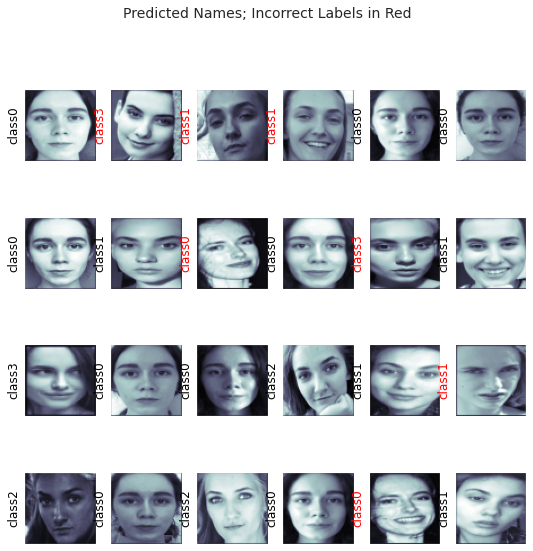

In [ ]:
fig, ax = plt.subplots(4, 6, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(64, 64), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel('class'+str(pred_lr[i]),
                   color='black' if pred_lr[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

# Аугментация


In [ ]:
import random
import albumentations as A
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

def get_aug(image):
    angle = np.arange(-10,11,1)
    angle0 = random.choice(angle)
    shift = 0.01*np.arange(-10,11,1)
    shift0 = random.choice(shift)
    transform = A.ShiftScaleRotate(shift_limit=shift0,rotate_limit=20,scale_limit=0,p=0.5)
    augmented_image = transform(image=image)['image']
    transform = A.HorizontalFlip(p=0.5)
    return transform(image=augmented_image)['image']

Сделаем обучающие и тестовые данные

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, stratify = y, random_state=42)

In [ ]:
len(Xtrain), len(Xtest)

(93, 32)

проведем аугментацию


In [ ]:
XtrainAug = []
ytrainAug = []

for (a, b) in zip(Xtrain, ytrain):
    for i in range(3):
      XtrainAug.append(get_aug(a))
      ytrainAug.append(b)

In [ ]:
XtrainAug = np.asarray([el.ravel() for el in XtrainAug])
Xtest = np.asarray([el.ravel() for el in Xtest])

In [ ]:
XtrainAug.shape, Xtest.shape

((279, 4096), (32, 4096))

Запустим обучение

In [ ]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression()
model_lr.fit(XtrainAug, ytrainAug)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
from sklearn.metrics import accuracy_score

pred_lr = model_lr.predict(Xtest)

accuracy_score(ytest, pred_lr)

0.75

# Теперь снизим размерность изображений для того, чтобы получить более точные предсказания и лучше обучить модель


In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA #Principal Components Analysis
from sklearn.pipeline import make_pipeline

pca = KernelPCA(n_components=200, kernel='poly', random_state=42)
model_lr = LogisticRegression()
model = make_pipeline(pca, model_lr)
model.fit(XtrainAug, ytrainAug)

Pipeline(steps=[('kernelpca',
                 KernelPCA(kernel='poly', n_components=200, random_state=42)),
                ('logisticregression', LogisticRegression())])

In [ ]:
from sklearn.metrics import accuracy_score

pred_lr = model.predict(Xtest)
accuracy_score(ytest, pred_lr)

0.75

Выведем матрицу совпадений

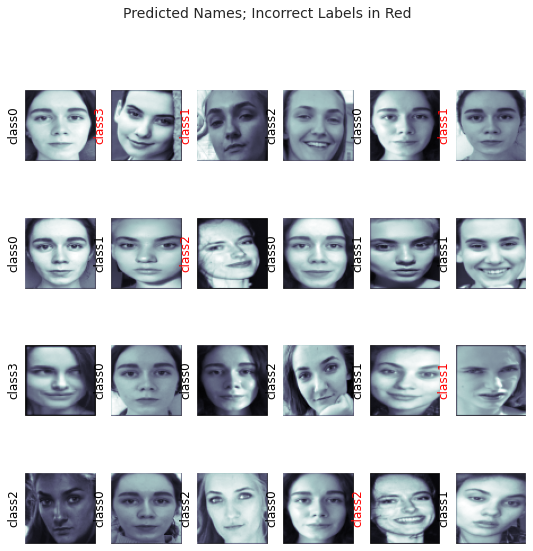

In [ ]:
fig, ax = plt.subplots(4, 6, figsize=(9,9))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(64, 64), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel('class'+str(pred_lr[i]),
                   color='black' if pred_lr[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);